# ProjectZ

## Import libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras import layers,models, backend
import matplotlib.pyplot as plt
import numpy as np
from six.moves import cPickle
import os
import sys
import cv2
import random
from sklearn.model_selection import train_test_split
import tensorflow.keras.preprocessing.image as image
from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa

In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
  local_device_protos = device_lib.list_local_devices()
  return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

['/device:GPU:0']


## Problem 0:
### Prepare a smart method to convert the stored image array into a standard library (open-cv, matplotlib etc.) interpretable format.


### Definition of functions for data reading and conversion：

In [3]:
def load_batch(fpath, label_key='labels'):
    
    with open(fpath, 'rb') as f:
        if sys.version_info < (3,):
            d = cPickle.load(f)
        else:
            d = cPickle.load(f, encoding='bytes')
            # decode utf8
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.decode('utf8')] = v
            d = d_decoded
    data = d['data']
    labels = d[label_key]
 
    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels
 
 
def load_data(ROOT):
   
    path = ROOT
 
    num_train_samples = 50000
 
    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8')
 
    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000: i * 10000, :, :, :],
         y_train[(i - 1) * 10000: i * 10000]) = load_batch(fpath)
 
    
 
    y_train = np.reshape(y_train, (len(y_train), 1))
   
 
    if backend.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        
 
    return (x_train, y_train)

### Use load_data function to convert data:

In [4]:
load_dir = './ProjectZ'
(train_examples, train_labels) = load_data(load_dir)

### Verify that the converted data is in a format interpretable by matplotlib:

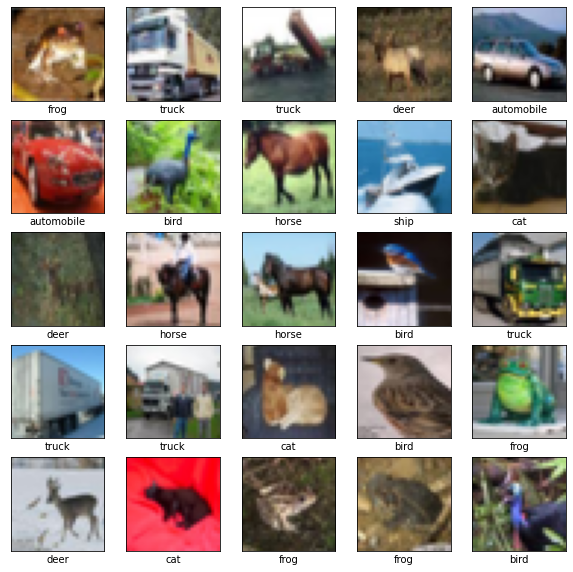

In [5]:
class_name =['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_examples[i],cmap=plt.cm.binary)
    plt.xlabel(class_name[train_labels[i][0]])
 
plt.show()

## Problem 1:
### Prepare an Image Classifier that can successfully predict the class labels of the images in context.


## Model_v0:
### Network structure:

### 1. Conv-BN-Relu Structure

In [6]:
class Convolution2D(object):
    def __init__(self, filters, ksize, strides=1, padding="valid", activation=None, kernel_regularizer=None):
        self.filters = filters
        self.kernel_regularizer = kernel_regularizer
        self.ksize = ksize
        self.strides = strides
        self.padding = padding
        self.activation = activation

    def __call__(self, x):
        x = layers.Conv2D(self.filters, self.ksize, self.strides, padding=self.padding,
                   kernel_regularizer=self.kernel_regularizer)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(self.activation)(x)
        return x


### 2. SENet (Squeeze-and-excitation blocks)
<br>A lightweight channel attention mechanism.The SE module first performs a Squeeze operation on the feature map obtained by convolution to get channel-level global features. Then performs an Excitation operation on the global features to learn the relationship between each channel, and also obtain the weights of different channels, and finally multiply the original feature map Get the final characteristics. Essentially, the SE module performs attention or gating operations in the channel dimension. This attention mechanism allows the model to pay more attention to the channel features with the largest amount of information, while suppressing those unimportant channel features. Another point is that the SE module is universal, which means it can be embedded in the existing network architecture.

In [7]:
class SEBlock(object):
    def __init__(self, se_rate=16, l2_rate=0.001):
        self.se_rate = se_rate
        self.l2_rate = l2_rate

    def __call__(self, inputs):
        shape = inputs.shape
        squeeze = layers.GlobalAveragePooling2D()(inputs)
        squeeze = layers.Dense(shape[-1] // self.se_rate, activation="relu")(squeeze)
        extract = layers.Dense(shape[-1], activation=tf.nn.sigmoid)(squeeze)
        extract = tf.expand_dims(extract, axis=1)
        extract = tf.expand_dims(extract, axis=1)
        output = tf.keras.layers.multiply([extract, inputs])
        return output

### 3. ResNet
Very classic image processing model.Use residual units to solve degradation problems.

In [8]:
class Residual(object):
    def __init__(self, filters, kernel_size, strides=1, padding='valid', activation=None):
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.activation = activation

    def __call__(self, inputs):
        x = Convolution2D(filters=self.filters[0],
                          ksize=(1, 1),
                          strides=self.strides,
                          padding=self.padding,
                          activation=self.activation)(inputs)
        x = Convolution2D(filters=self.filters[1],
                          ksize=self.kernel_size,
                          strides=self.strides,
                          padding=self.padding,
                          activation=self.activation)(x)
        x = Convolution2D(filters=self.filters[2],
                          ksize=(1, 1),
                          strides=self.strides,
                          padding=self.padding,
                          activation=None)(x)
        x = SEBlock(se_rate=16)(x)
        if x.shape.as_list()[-1] != inputs.shape.as_list()[-1]:
            inputs = Convolution2D(filters=self.filters[2],
                                   ksize=(1, 1),
                                   strides=self.strides,
                                   padding=self.padding,
                                   activation=None)(inputs)
        x = tf.keras.layers.add([inputs, x])
        x = tf.keras.layers.Activation(self.activation)(x)
        return x




### 4. SE+ResNet
Paper:[Squeeze-and-Excitation Networks](https://arxiv.org/pdf/1709.01507v4.pdf)
<br>Github: https://github.com/rwightman/pytorch-image-models/blob/a7f95818e44b281137503bcf4b3e3e94d8ffa52f/timm/models/resnet.py#L1180
This model has received high scores on Imagenet.

In [9]:
class SEResNet50(object):
    def __init__(self, se_rate=16, l2_rate=0, drop_rate=0.25):
        self.se_rate = se_rate
        self.l2_rate = l2_rate
        self.drop_rate = drop_rate

    def __call__(self, inputs):
        x = Convolution2D(32, [3, 3], [1, 1], activation="relu", padding="same")(inputs)

        x = Residual([32, 32, 128], [3, 3], [1, 1], activation="relu", padding="same")(x)
        x = Residual([32, 32, 128], [3, 3], [1, 1], activation="relu", padding="same")(x)
        x = Residual([32, 32, 128], [3, 3], [1, 1], activation="relu", padding="same")(x)
        x = layers.MaxPooling2D([3, 3], [2, 2], padding="same")(x)

        x = Residual([64, 64, 256], [3, 3], [1, 1], activation="relu", padding="same")(x)
        x = Residual([64, 64, 256], [3, 3], [1, 1], activation="relu", padding="same")(x)
        x = Residual([64, 64, 256], [3, 3], [1, 1], activation="relu", padding="same")(x)
        x = layers.Dropout(self.drop_rate)(x)
        x = Residual([64, 64, 256], [3, 3], [1, 1], activation="relu", padding="same")(x)
        x = layers.MaxPooling2D([3, 3], [2, 2], padding="same")(x)

        x = Residual([128, 128, 512], [3, 3], [1, 1], activation="relu", padding="same")(x)
        x = Residual([128, 128, 512], [3, 3], [1, 1], activation="relu", padding="same")(x)
        x = Residual([128, 128, 512], [3, 3], [1, 1], activation="relu", padding="same")(x)
        x = Residual([128, 128, 512], [3, 3], [1, 1], activation="relu", padding="same")(x)
        x = Residual([128, 128, 512], [3, 3], [1, 1], activation="relu", padding="same")(x)
        x = Residual([128, 128, 512], [3, 3], [1, 1], activation="relu", padding="same")(x)
        x = layers.Dropout(self.drop_rate)(x)
        x = layers.MaxPooling2D([3, 3], [2, 2], padding="same")(x)

        x = Residual([256, 256, 1024], [3, 3], [1, 1], activation="relu", padding="same")(x)
        x = Residual([256, 256, 1024], [3, 3], [1, 1], activation="relu", padding="same")(x)
        x = Residual([256, 256, 1024], [3, 3], [1, 1], activation="relu", padding="same")(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(self.drop_rate)(x)

        x = layers.Dense(10, activation="softmax")(x)
        print(self)
        return x

## Use ImageDataGenerator to do some data augmentation

In [10]:
batch_size=128
x_train, x_vail, y_train, y_vail = train_test_split(
    train_examples, train_labels,               
    test_size=0.1        
)
train_datagen = image.ImageDataGenerator(
        rescale=1 / 255,
        rotation_range=40,  # range for random rotations
        width_shift_range=0.2,  # random shift,fraction of total width
        height_shift_range=0.2,
        horizontal_flip=True,  # Randomly flip inputs horizontally.
        fill_mode='nearest'  # Randomly flip inputs vertically.
    )

test_datagen = image.ImageDataGenerator(rescale=1 / 255)

validation_datagen = image.ImageDataGenerator(rescale=1 / 255)

train_generator = train_datagen.flow(x_train, y_train, batch_size=128)
# train_generator = train_datagen.flow(x_train, y_train, batch_size=128)
validation_generator = validation_datagen.flow(x_vail, y_vail, batch_size=128)

#test_generator = test_datagen.flow(x_test, y_test, batch_size=128)



## Check the data shape

In [11]:
sample = next(iter(train_generator))
print('sample:', sample[0].shape, sample[1].shape,
      tf.reduce_min(sample[0]),
      tf.reduce_max(sample[0]))  


sample: (128, 32, 32, 3) (128, 1) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


## Training process
The model with the highest verification accuracy will be saved in the 'final_model' folder.

In [14]:
checkpoint=tf.keras.callbacks.ModelCheckpoint('final_model',
                           monitor='val_sparse_categorical_accuracy',
                           verbose=1,
                           mode='max',
                           save_weights_only=False,
                           save_best_only=True,
                           period=1)

with tf.device("/gpu:0"): 
    inputs=layers.Input(shape=[32,32,3]) 
    outputs=SEResNet50()(inputs)
    model=models.Model(inputs,outputs)
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(lr=0.001),
                  metrics=['sparse_categorical_accuracy'])
    trained_model=model.fit(
        train_generator,
        steps_per_epoch=45000//batch_size,
        shuffle=True,
        epochs=300,
        validation_data= validation_generator,
        validation_steps=5000//batch_size,
        callbacks=[checkpoint]
    )

Epoch 1/300
351/351 [==============================] - ETA: 0s - loss: 1.7408 - sparse_categorical_accuracy: 0.3944
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.11959, saving model to final_model
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: final_model\assets
351/351 [==============================] - 66s 188ms/step - loss: 1.7408 - sparse_categorical_accuracy: 0.3944 - val_loss: 3.6967 - val_sparse_categorical_accuracy: 0.1196
Epoch 2/300
351/351 [==============================] - ETA: 0s - loss: 1.3374 - sparse_categorical_accuracy: 0.5247
Epoch 00002: val_sparse_categorical_accuracy improved from 0.11959 to 0.24339, saving model to final_model
INFO:tensorflow:Assets written to: final_model\assets
351/351 [==============================] - 

Epoch 41/300
351/351 [==============================] - ETA: 0s - loss: 0.2048 - sparse_categorical_accuracy: 0.9271
Epoch 00041: val_sparse_categorical_accuracy did not improve from 0.85417
351/351 [==============================] - 44s 126ms/step - loss: 0.2048 - sparse_categorical_accuracy: 0.9271 - val_loss: 0.6884 - val_sparse_categorical_accuracy: 0.7734
Epoch 42/300
351/351 [==============================] - ETA: 0s - loss: 0.2044 - sparse_categorical_accuracy: 0.9290
Epoch 00042: val_sparse_categorical_accuracy did not improve from 0.85417
351/351 [==============================] - 44s 127ms/step - loss: 0.2044 - sparse_categorical_accuracy: 0.9290 - val_loss: 0.5661 - val_sparse_categorical_accuracy: 0.8101
Epoch 43/300
351/351 [==============================] - ETA: 0s - loss: 0.1987 - sparse_categorical_accuracy: 0.9300
Epoch 00043: val_sparse_categorical_accuracy did not improve from 0.85417
351/351 [==============================] - 44s 127ms/step - loss: 0.1987 - sparse_c

Epoch 86/300
351/351 [==============================] - ETA: 0s - loss: 0.0929 - sparse_categorical_accuracy: 0.9675
Epoch 00086: val_sparse_categorical_accuracy did not improve from 0.85998
351/351 [==============================] - 46s 131ms/step - loss: 0.0929 - sparse_categorical_accuracy: 0.9675 - val_loss: 0.5781 - val_sparse_categorical_accuracy: 0.8167
Epoch 87/300
351/351 [==============================] - ETA: 0s - loss: 0.0916 - sparse_categorical_accuracy: 0.9679
Epoch 00087: val_sparse_categorical_accuracy did not improve from 0.85998
351/351 [==============================] - 47s 135ms/step - loss: 0.0916 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.4479 - val_sparse_categorical_accuracy: 0.8588
Epoch 88/300
351/351 [==============================] - ETA: 0s - loss: 0.0855 - sparse_categorical_accuracy: 0.9699
Epoch 00088: val_sparse_categorical_accuracy did not improve from 0.85998
351/351 [==============================] - 46s 132ms/step - loss: 0.0855 - sparse_c

Epoch 108/300
351/351 [==============================] - ETA: 0s - loss: 0.0743 - sparse_categorical_accuracy: 0.9743
Epoch 00108: val_sparse_categorical_accuracy did not improve from 0.86999
351/351 [==============================] - 45s 128ms/step - loss: 0.0743 - sparse_categorical_accuracy: 0.9743 - val_loss: 0.6453 - val_sparse_categorical_accuracy: 0.8151
Epoch 109/300
351/351 [==============================] - ETA: 0s - loss: 0.0698 - sparse_categorical_accuracy: 0.9771
Epoch 00109: val_sparse_categorical_accuracy did not improve from 0.86999
351/351 [==============================] - 45s 127ms/step - loss: 0.0698 - sparse_categorical_accuracy: 0.9771 - val_loss: 0.5283 - val_sparse_categorical_accuracy: 0.8452
Epoch 110/300
351/351 [==============================] - ETA: 0s - loss: 0.0674 - sparse_categorical_accuracy: 0.9770
Epoch 00110: val_sparse_categorical_accuracy did not improve from 0.86999
351/351 [==============================] - 45s 127ms/step - loss: 0.0674 - spars

351/351 [==============================] - ETA: 0s - loss: 0.0551 - sparse_categorical_accuracy: 0.9811
Epoch 00152: val_sparse_categorical_accuracy did not improve from 0.88742
351/351 [==============================] - 45s 127ms/step - loss: 0.0551 - sparse_categorical_accuracy: 0.9811 - val_loss: 0.4536 - val_sparse_categorical_accuracy: 0.8496
Epoch 153/300
351/351 [==============================] - ETA: 0s - loss: 0.0474 - sparse_categorical_accuracy: 0.9842
Epoch 00153: val_sparse_categorical_accuracy did not improve from 0.88742
351/351 [==============================] - 45s 127ms/step - loss: 0.0474 - sparse_categorical_accuracy: 0.9842 - val_loss: 0.4645 - val_sparse_categorical_accuracy: 0.8540
Epoch 154/300
351/351 [==============================] - ETA: 0s - loss: 0.0515 - sparse_categorical_accuracy: 0.9820
Epoch 00154: val_sparse_categorical_accuracy did not improve from 0.88742
351/351 [==============================] - 45s 127ms/step - loss: 0.0515 - sparse_categorical_

Epoch 175/300
351/351 [==============================] - ETA: 0s - loss: 0.0475 - sparse_categorical_accuracy: 0.9840
Epoch 00175: val_sparse_categorical_accuracy did not improve from 0.88742
351/351 [==============================] - 45s 130ms/step - loss: 0.0475 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.4594 - val_sparse_categorical_accuracy: 0.8578
Epoch 176/300
351/351 [==============================] - ETA: 0s - loss: 0.0438 - sparse_categorical_accuracy: 0.9854
Epoch 00176: val_sparse_categorical_accuracy did not improve from 0.88742
351/351 [==============================] - 46s 130ms/step - loss: 0.0438 - sparse_categorical_accuracy: 0.9854 - val_loss: 0.6051 - val_sparse_categorical_accuracy: 0.8353
Epoch 177/300
351/351 [==============================] - ETA: 0s - loss: 0.0432 - sparse_categorical_accuracy: 0.9846
Epoch 00177: val_sparse_categorical_accuracy did not improve from 0.88742
351/351 [==============================] - 46s 130ms/step - loss: 0.0432 - spars

Epoch 198/300
351/351 [==============================] - ETA: 0s - loss: 0.0408 - sparse_categorical_accuracy: 0.9867
Epoch 00198: val_sparse_categorical_accuracy did not improve from 0.88742
351/351 [==============================] - 44s 126ms/step - loss: 0.0408 - sparse_categorical_accuracy: 0.9867 - val_loss: 0.4819 - val_sparse_categorical_accuracy: 0.8650
Epoch 199/300
351/351 [==============================] - ETA: 0s - loss: 0.0403 - sparse_categorical_accuracy: 0.9862
Epoch 00199: val_sparse_categorical_accuracy did not improve from 0.88742
351/351 [==============================] - 44s 126ms/step - loss: 0.0403 - sparse_categorical_accuracy: 0.9862 - val_loss: 0.4001 - val_sparse_categorical_accuracy: 0.8764
Epoch 200/300
351/351 [==============================] - ETA: 0s - loss: 0.0441 - sparse_categorical_accuracy: 0.9849
Epoch 00200: val_sparse_categorical_accuracy did not improve from 0.88742
351/351 [==============================] - 44s 126ms/step - loss: 0.0441 - spars

Epoch 221/300
351/351 [==============================] - ETA: 0s - loss: 0.0369 - sparse_categorical_accuracy: 0.9873
Epoch 00221: val_sparse_categorical_accuracy did not improve from 0.88742
351/351 [==============================] - 44s 126ms/step - loss: 0.0369 - sparse_categorical_accuracy: 0.9873 - val_loss: 0.6084 - val_sparse_categorical_accuracy: 0.8373
Epoch 222/300
351/351 [==============================] - ETA: 0s - loss: 0.0476 - sparse_categorical_accuracy: 0.9842
Epoch 00222: val_sparse_categorical_accuracy did not improve from 0.88742
351/351 [==============================] - 44s 125ms/step - loss: 0.0476 - sparse_categorical_accuracy: 0.9842 - val_loss: 0.5453 - val_sparse_categorical_accuracy: 0.8504
Epoch 223/300
351/351 [==============================] - ETA: 0s - loss: 0.0409 - sparse_categorical_accuracy: 0.9862
Epoch 00223: val_sparse_categorical_accuracy did not improve from 0.88742
351/351 [==============================] - 44s 126ms/step - loss: 0.0409 - spars

Epoch 266/300
351/351 [==============================] - ETA: 0s - loss: 0.0304 - sparse_categorical_accuracy: 0.9896
Epoch 00266: val_sparse_categorical_accuracy did not improve from 0.88922
351/351 [==============================] - 44s 126ms/step - loss: 0.0304 - sparse_categorical_accuracy: 0.9896 - val_loss: 0.6434 - val_sparse_categorical_accuracy: 0.8389
Epoch 267/300
351/351 [==============================] - ETA: 0s - loss: 0.0307 - sparse_categorical_accuracy: 0.9894
Epoch 00267: val_sparse_categorical_accuracy did not improve from 0.88922
351/351 [==============================] - 44s 126ms/step - loss: 0.0307 - sparse_categorical_accuracy: 0.9894 - val_loss: 0.4631 - val_sparse_categorical_accuracy: 0.8700
Epoch 268/300
351/351 [==============================] - ETA: 0s - loss: 0.0325 - sparse_categorical_accuracy: 0.9889
Epoch 00268: val_sparse_categorical_accuracy did not improve from 0.88922
351/351 [==============================] - 44s 126ms/step - loss: 0.0325 - spars

Epoch 289/300
351/351 [==============================] - ETA: 0s - loss: 0.0315 - sparse_categorical_accuracy: 0.9893
Epoch 00289: val_sparse_categorical_accuracy did not improve from 0.88922
351/351 [==============================] - 44s 126ms/step - loss: 0.0315 - sparse_categorical_accuracy: 0.9893 - val_loss: 0.4829 - val_sparse_categorical_accuracy: 0.8640
Epoch 290/300
351/351 [==============================] - ETA: 0s - loss: 0.0262 - sparse_categorical_accuracy: 0.9914
Epoch 00290: val_sparse_categorical_accuracy did not improve from 0.88922
351/351 [==============================] - 44s 126ms/step - loss: 0.0262 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.5716 - val_sparse_categorical_accuracy: 0.8508
Epoch 291/300
351/351 [==============================] - ETA: 0s - loss: 0.0297 - sparse_categorical_accuracy: 0.9899
Epoch 00291: val_sparse_categorical_accuracy did not improve from 0.88922
351/351 [==============================] - 44s 126ms/step - loss: 0.0297 - spars

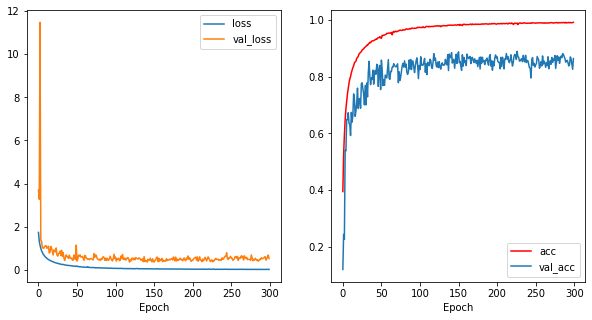

In [62]:
hist = trained_model.history
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.plot(hist['loss'],
       label='loss')
plt.plot( hist['val_loss'],
       label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.plot( hist['sparse_categorical_accuracy'],
       label = 'acc',color = 'red')
plt.plot( hist['val_sparse_categorical_accuracy'],
       label = 'val_acc')
plt.legend()

# Model_v1:
#### 1. Use cut out method for Data Augmentation
Paper: [Improved Regularization of Convolutional Neural Networks with Cutout.](https://arxiv.org/pdf/1708.04552.pdf) 
Github: https://github.com/uoguelph-mlrg/Cutout.  
<br>This technique encourages the network to better utilize the full context of the image, rather than relying on the presence of a small set of specific visual features. 

#### 2. Use tf.data.Dataset format to process datasets.

### Rewrite Dataset Read Function

In [12]:
def image_augmentation(images,
                       width_shift_range=0., height_shift_range=0.,
                       rotation_range = 0.0, 
                       horizontal_flip=False,
                       vertical_flip=False,
                       cval=0.0, cutout_size=None, cutout_num=1, 
                       ):

    img_shape = images.shape[-3:]
    img_width = img_shape[1]
    img_height = img_shape[0]
    interpolation  = 'BILINEAR' if rotation_range!=0.0 else 'NEAREST'

    def transform(image):
        mirror_x = tf.cast(tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.dtypes.int32)*2-1, tf.float32) if horizontal_flip else 1.0
        mirror_y = tf.cast(tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.dtypes.int32)*2-1, tf.float32) if vertical_flip else 1.0
        width_shift = tf.random.uniform(shape=[], minval=-width_shift_range, maxval=width_shift_range)*img_width
        height_shift = tf.random.uniform(shape=[], minval=-height_shift_range, maxval=height_shift_range)*img_width
        zoom_x = 1.0
        zoom_y = 1.0
        center = img_width/2

        angle = tf.random.uniform(shape=[], minval=-rotation_range, maxval=rotation_range)*3.141519/180
        sinval = tf.sin(angle)
        cosval = tf.cos(angle)
        center_mat = [1.0, 0.0, center, 0.0, 1.0, center, 0.0, 0.0]
        rotate_mat = [cosval, -sinval, 0.0, sinval, cosval, 0.0, 0.0, 0.0]
        zoom_mat = [zoom_x*mirror_x, 0.0, 0.0, 0.0, zoom_y*mirror_y, 0.0, 0.0, 0.0]
        center_mat_inv = [1.0, 0.0, width_shift-center, 0.0, 1.0, height_shift-center, 0.0, 0.0]
        matrix = [center_mat, rotate_mat, zoom_mat, center_mat_inv]
        composed_matrix = tfa.image.transform_ops.compose_transforms(matrix)
        (h, w, c) = (img_shape[0], img_shape[1], img_shape[2])
        images = tf.reshape( image, [1, h, w, c] )
        images = tf.raw_ops.ImageProjectiveTransformV2(
            images=images, transforms=composed_matrix, output_shape=[h, w], 
            fill_mode='REFLECT', interpolation=interpolation)
        image = tf.reshape( images, [h, w, c] )
        return image

    def cutout(image, cval=0, cnum = 6, csize = 0.25):
        DIM = image.shape[0]
        for k in range( cnum ):
            # CHOOSE RANDOM LOCATION
            x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
            y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
            # COMPUTE SQUARE 
            WIDTH = tf.cast( csize*DIM,tf.int32)
            ya = tf.math.maximum(0,y-WIDTH//2)
            yb = tf.math.minimum(DIM,y+WIDTH//2)
            xa = tf.math.maximum(0,x-WIDTH//2)
            xb = tf.math.minimum(DIM,x+WIDTH//2)
            # DROPOUT IMAGE
            one = image[ya:yb,0:xa,:]
            two = tf.fill([yb-ya,xb-xa,3], tf.cast(cval, image.dtype) ) 
            three = image[ya:yb,xb:DIM,:]
            middle = tf.concat([one,two,three],axis=1)
            image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)

        # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR 
        image = tf.reshape(image,[DIM,DIM,3])
        return image


    images = tf.map_fn(lambda image: transform(image), images)


    if cutout_size!=None and cutout_num!=0:
        images = tf.map_fn(lambda image: cutout(image,cval=cval, csize=cutout_size, cnum=cutout_num), images)
    return images

def make_dataset(train_data, validation_data, batch_size, cutout_size=0.25, cutout_num=1):
    (x_train, label_train) = train_data
    (x_test, label_test) = validation_data

    train_len = len(x_train)
    test_len = len(x_test)

    ds_train = tf.data.Dataset.from_tensor_slices(train_data)
    ds_train = ds_train.shuffle(train_len).batch(batch_size)
    ds_validation = tf.data.Dataset.from_tensor_slices(validation_data)
    ds_validation = ds_validation.batch(batch_size)

    def data_augmentation(images, labels, aug):
        if aug:
            images = image_augmentation(images, 
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        horizontal_flip=True,
                                        cval=127.0,
                                        cutout_size=cutout_size, cutout_num=cutout_num,
                                        )

        
        return images, labels

    ds_train = ds_train.map(lambda image, label: data_augmentation(image, label,True), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

    ds_validation = ds_validation.map(lambda image, label: data_augmentation(image, label,False), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds_validation = ds_validation.prefetch(tf.data.experimental.AUTOTUNE)
    return ds_train, ds_validation


### Simply Ceat Datasets

In [13]:
train_data = (x_train, to_categorical(y_train))
validation_data = (x_vail, to_categorical(y_vail)) 
ds_train, ds_validation = make_dataset(train_data, validation_data, 128, 0.5, 1)

In [14]:
ds_train 

<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.uint8, tf.float32)>

In [15]:
ds_validation

<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.uint8, tf.float32)>

In [30]:
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy(name='acc')
checkpoint=tf.keras.callbacks.ModelCheckpoint('final_model_v1',
                           monitor='val_acc',
                           verbose=1,
                           mode='max',
                           save_weights_only=False,
                           save_best_only=True,
                           period=1)

with tf.device("/gpu:0"): 
    inputs=layers.Input(shape=[32,32,3]) 
    outputs=SEResNet50()(inputs)
    model=models.Model(inputs,outputs)
    model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(lr=0.001),
                  metrics=[acc])
    trained_model=model.fit(
        ds_train,
        steps_per_epoch=352,
        shuffle=True,
        epochs=300,
        validation_data=ds_validation,
        validation_steps=40,
        callbacks=[checkpoint]
    )

Epoch 1/300
352/352 [==============================] - ETA: 0s - loss: 1.6667 - acc: 0.4158
Epoch 00001: val_acc improved from -inf to 0.22060, saving model to final_model_v1
INFO:tensorflow:Assets written to: final_model_v1\assets
352/352 [==============================] - 62s 175ms/step - loss: 1.6667 - acc: 0.4158 - val_loss: 2.9798 - val_acc: 0.2206
Epoch 2/300
352/352 [==============================] - ETA: 0s - loss: 1.2135 - acc: 0.5652
Epoch 00002: val_acc improved from 0.22060 to 0.37380, saving model to final_model_v1
INFO:tensorflow:Assets written to: final_model_v1\assets
352/352 [==============================] - 62s 176ms/step - loss: 1.2135 - acc: 0.5652 - val_loss: 1.8715 - val_acc: 0.3738
Epoch 3/300
352/352 [==============================] - ETA: 0s - loss: 1.0007 - acc: 0.6437
Epoch 00003: val_acc improved from 0.37380 to 0.54480, saving model to final_model_v1
INFO:tensorflow:Assets written to: final_model_v1\assets
352/352 [==============================] - 61s 175

Epoch 56/300
352/352 [==============================] - ETA: 0s - loss: 0.1834 - acc: 0.9354
Epoch 00056: val_acc did not improve from 0.90040
352/352 [==============================] - 51s 145ms/step - loss: 0.1834 - acc: 0.9354 - val_loss: 0.3630 - val_acc: 0.8744
Epoch 57/300
352/352 [==============================] - ETA: 0s - loss: 0.1785 - acc: 0.9372
Epoch 00057: val_acc improved from 0.90040 to 0.90720, saving model to final_model_v1
INFO:tensorflow:Assets written to: final_model_v1\assets
352/352 [==============================] - 76s 215ms/step - loss: 0.1785 - acc: 0.9372 - val_loss: 0.2751 - val_acc: 0.9072
Epoch 58/300
352/352 [==============================] - ETA: 0s - loss: 0.1736 - acc: 0.9390
Epoch 00058: val_acc did not improve from 0.90720
352/352 [==============================] - 49s 141ms/step - loss: 0.1736 - acc: 0.9390 - val_loss: 0.4143 - val_acc: 0.8566
Epoch 59/300
352/352 [==============================] - ETA: 0s - loss: 0.1701 - acc: 0.9407
Epoch 00059: 

Epoch 85/300
352/352 [==============================] - ETA: 0s - loss: 0.1256 - acc: 0.9561
Epoch 00085: val_acc did not improve from 0.91740
352/352 [==============================] - 52s 148ms/step - loss: 0.1256 - acc: 0.9561 - val_loss: 0.2678 - val_acc: 0.9094
Epoch 86/300
352/352 [==============================] - ETA: 0s - loss: 0.1287 - acc: 0.9547
Epoch 00086: val_acc did not improve from 0.91740
352/352 [==============================] - 52s 148ms/step - loss: 0.1287 - acc: 0.9547 - val_loss: 0.3211 - val_acc: 0.8884
Epoch 87/300
352/352 [==============================] - ETA: 0s - loss: 0.1256 - acc: 0.9556
Epoch 00087: val_acc did not improve from 0.91740
352/352 [==============================] - 50s 143ms/step - loss: 0.1256 - acc: 0.9556 - val_loss: 0.3193 - val_acc: 0.8882
Epoch 88/300
352/352 [==============================] - ETA: 0s - loss: 0.1268 - acc: 0.9559
Epoch 00088: val_acc did not improve from 0.91740
352/352 [==============================] - 51s 145ms/ste

Epoch 116/300
352/352 [==============================] - ETA: 0s - loss: 0.1358 - acc: 0.9533
Epoch 00116: val_acc did not improve from 0.91740
352/352 [==============================] - 51s 145ms/step - loss: 0.1358 - acc: 0.9533 - val_loss: 0.2631 - val_acc: 0.9144
Epoch 117/300
352/352 [==============================] - ETA: 0s - loss: 0.1007 - acc: 0.9650
Epoch 00117: val_acc did not improve from 0.91740
352/352 [==============================] - 50s 143ms/step - loss: 0.1007 - acc: 0.9650 - val_loss: 0.2683 - val_acc: 0.9116
Epoch 118/300
352/352 [==============================] - ETA: 0s - loss: 0.0948 - acc: 0.9670
Epoch 00118: val_acc did not improve from 0.91740
352/352 [==============================] - 51s 145ms/step - loss: 0.0948 - acc: 0.9670 - val_loss: 0.2499 - val_acc: 0.9144
Epoch 119/300
352/352 [==============================] - ETA: 0s - loss: 0.0950 - acc: 0.9668
Epoch 00119: val_acc did not improve from 0.91740
352/352 [==============================] - 51s 145ms

352/352 [==============================] - ETA: 0s - loss: 0.0779 - acc: 0.9729
Epoch 00175: val_acc did not improve from 0.93480
352/352 [==============================] - 50s 143ms/step - loss: 0.0779 - acc: 0.9729 - val_loss: 0.2375 - val_acc: 0.9188
Epoch 176/300
352/352 [==============================] - ETA: 0s - loss: 0.0723 - acc: 0.9746
Epoch 00176: val_acc did not improve from 0.93480
352/352 [==============================] - 51s 144ms/step - loss: 0.0723 - acc: 0.9746 - val_loss: 0.2762 - val_acc: 0.9152
Epoch 177/300
352/352 [==============================] - ETA: 0s - loss: 0.0718 - acc: 0.9745
Epoch 00177: val_acc did not improve from 0.93480
352/352 [==============================] - 50s 143ms/step - loss: 0.0718 - acc: 0.9745 - val_loss: 0.2259 - val_acc: 0.9284
Epoch 178/300
352/352 [==============================] - ETA: 0s - loss: 0.0713 - acc: 0.9753
Epoch 00178: val_acc did not improve from 0.93480
352/352 [==============================] - 51s 145ms/step - loss: 

Epoch 206/300
352/352 [==============================] - ETA: 0s - loss: 0.0662 - acc: 0.9775
Epoch 00206: val_acc did not improve from 0.93480
352/352 [==============================] - 50s 143ms/step - loss: 0.0662 - acc: 0.9775 - val_loss: 0.2246 - val_acc: 0.9288
Epoch 207/300
352/352 [==============================] - ETA: 0s - loss: 0.0607 - acc: 0.9786
Epoch 00207: val_acc did not improve from 0.93480
352/352 [==============================] - 50s 142ms/step - loss: 0.0607 - acc: 0.9786 - val_loss: 0.2308 - val_acc: 0.9232
Epoch 208/300
352/352 [==============================] - ETA: 0s - loss: 0.0650 - acc: 0.9776
Epoch 00208: val_acc did not improve from 0.93480
352/352 [==============================] - 51s 144ms/step - loss: 0.0650 - acc: 0.9776 - val_loss: 0.2457 - val_acc: 0.9174
Epoch 209/300
352/352 [==============================] - ETA: 0s - loss: 0.0667 - acc: 0.9770
Epoch 00209: val_acc did not improve from 0.93480
352/352 [==============================] - 51s 144ms

Epoch 237/300
352/352 [==============================] - ETA: 0s - loss: 0.0588 - acc: 0.9790
Epoch 00237: val_acc did not improve from 0.93480
352/352 [==============================] - 50s 142ms/step - loss: 0.0588 - acc: 0.9790 - val_loss: 0.2220 - val_acc: 0.9266
Epoch 238/300
352/352 [==============================] - ETA: 0s - loss: 0.0568 - acc: 0.9804
Epoch 00238: val_acc did not improve from 0.93480
352/352 [==============================] - 51s 144ms/step - loss: 0.0568 - acc: 0.9804 - val_loss: 0.2809 - val_acc: 0.9100
Epoch 239/300
352/352 [==============================] - ETA: 0s - loss: 0.0609 - acc: 0.9780
Epoch 00239: val_acc did not improve from 0.93480
352/352 [==============================] - 50s 142ms/step - loss: 0.0609 - acc: 0.9780 - val_loss: 0.2679 - val_acc: 0.9138
Epoch 240/300
352/352 [==============================] - ETA: 0s - loss: 0.0601 - acc: 0.9790
Epoch 00240: val_acc did not improve from 0.93480
352/352 [==============================] - 50s 142ms

Epoch 268/300
352/352 [==============================] - ETA: 0s - loss: 0.0530 - acc: 0.9811
Epoch 00268: val_acc did not improve from 0.93480
352/352 [==============================] - 43s 121ms/step - loss: 0.0530 - acc: 0.9811 - val_loss: 0.2312 - val_acc: 0.9230
Epoch 269/300
352/352 [==============================] - ETA: 0s - loss: 0.0517 - acc: 0.9821
Epoch 00269: val_acc did not improve from 0.93480
352/352 [==============================] - 43s 122ms/step - loss: 0.0517 - acc: 0.9821 - val_loss: 0.2186 - val_acc: 0.9266
Epoch 270/300
352/352 [==============================] - ETA: 0s - loss: 0.0539 - acc: 0.9814
Epoch 00270: val_acc did not improve from 0.93480
352/352 [==============================] - 43s 123ms/step - loss: 0.0539 - acc: 0.9814 - val_loss: 0.2020 - val_acc: 0.9296
Epoch 271/300
352/352 [==============================] - ETA: 0s - loss: 0.0541 - acc: 0.9813
Epoch 00271: val_acc did not improve from 0.93480
352/352 [==============================] - 43s 123ms

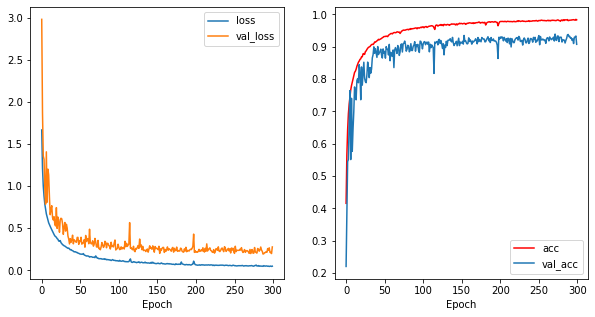

In [80]:
hist = trained_model.history
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.plot(hist['loss'],
       label='loss')
plt.plot( hist['val_loss'],
       label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.plot( hist['acc'],
       label = 'acc',color = 'red')
plt.plot( hist['val_acc'],
       label = 'val_acc')
plt.legend()

## Result: val_acc increased from 88.9% to 93.9%

# Model_v2: 
### Cosine annealing decay strategy:
The learning rate will increase at the beginning to speed up the convergence of the model and find the best position. After reaching a certain step, the learning rate will decrease. At this time, we can consider this to be a process of fine-tuning the model. A linear rise is used for the rise, and a cos function is used for the fall.

In [74]:
def exponent(global_epoch,
            learning_rate_base,
            decay_rate,
            min_learn_rate=0,
            ):

    learning_rate = learning_rate_base * pow(decay_rate, global_epoch)
    learning_rate = max(learning_rate,min_learn_rate)
    return learning_rate

class ExponentDecayScheduler(keras.callbacks.Callback):
   
    def __init__(self,
                 learning_rate_base,
                 decay_rate,
                 global_epoch_init=0,
                 min_learn_rate=0,
                 verbose=0):
        super(ExponentDecayScheduler, self).__init__()

        self.learning_rate_base = learning_rate_base
       
        self.global_epoch = global_epoch_init

        self.decay_rate = decay_rate
       
        self.verbose = verbose
        
        self.min_learn_rate = min_learn_rate
        self.learning_rates = []

    def on_epoch_end(self, epochs ,logs=None):
        self.global_epoch = self.global_epoch + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_epoch_begin(self, batch, logs=None):
        lr = exponent(global_epoch=self.global_epoch,
                    learning_rate_base=self.learning_rate_base,
                    decay_rate = self.decay_rate,
                    min_learn_rate = self.min_learn_rate)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: setting learning '
                  'rate to %s.' % (self.global_epoch + 1, lr))

In [77]:
epoch = 300

init_epoch = 0

batch_size = 256

learning_rate_base = 1e-2


exponent_lr = ExponentDecayScheduler(learning_rate_base = learning_rate_base,
                                    global_epoch_init = init_epoch,
                                    decay_rate = 0.9,
                                    min_learn_rate = 5e-5
                                    )


In [ ]:


loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy(name='acc')
checkpoint=tf.keras.callbacks.ModelCheckpoint('final_model_v2',
                           monitor='val_acc',
                           verbose=1,
                           mode='max',
                           save_weights_only=False,
                           save_best_only=True,
                           period=1)

with tf.device("/gpu:0"): 
    inputs=layers.Input(shape=[32,32,3]) 
    outputs=SEResNet50()(inputs)
    model=models.Model(inputs,outputs)
    model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[acc])
    trained_model=model.fit(
        ds_train,
        steps_per_epoch=352,
        shuffle=True,
        epochs=epoch,
        validation_data=ds_validation,
        validation_steps=40,
        callbacks=[checkpoint, exponent_lr]
    )

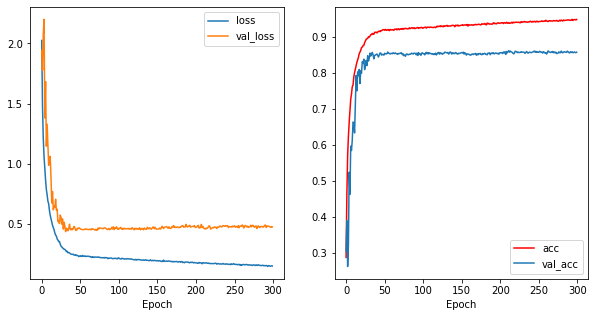

In [80]:
hist = trained_model.history
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.plot(hist['loss'],
       label='loss')
plt.plot( hist['val_loss'],
       label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.plot( hist['acc'],
       label = 'acc',color = 'red')
plt.plot( hist['val_acc'],
       label = 'val_acc')
plt.legend()

# The best model is final_model_v1

### Use CIfar-10 test dataset to evaluate.

In [93]:
model_1=tf.keras.models.load_model('final_model_v1')
(x, y), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
train_data = (x_train, to_categorical(y_train))
test_data = (x_test, to_categorical(y_test)) 
ds_train, ds_test = make_dataset(train_data, validation_data, 128, 0.5, 1)

In [94]:
model_1.evaluate(ds_test)

79/79 [==============================] - 3s 32ms/step - loss: 0.2232 - acc: 0.9265


[0.22318989038467407, 0.9265000224113464]

### Test Accuracy: 92.65%

In [16]:
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy(name='acc')
checkpoint=tf.keras.callbacks.ModelCheckpoint('final_model_v3',
                           monitor='val_acc',
                           verbose=1,
                           mode='max',
                           save_weights_only=False,
                           save_best_only=True,
                           period=1)

with tf.device("/gpu:0"): 
    inputs=layers.Input(shape=[32,32,3]) 
    outputs=SEResNet50()(inputs)
    model=models.Model(inputs,outputs)
    model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(lr=0.01),
                  metrics=[acc])
    trained_model=model.fit(
        ds_train,
        steps_per_epoch=352,
        shuffle=True,
        epochs=300,
        validation_data=ds_validation,
        validation_steps=40,
        callbacks=[checkpoint]
    )

Epoch 1/300
352/352 [==============================] - ETA: 0s - loss: 2.0427 - acc: 0.2991
Epoch 00001: val_acc improved from -inf to 0.22080, saving model to final_model_v3
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: final_model_v3\assets
352/352 [==============================] - 110s 314ms/step - loss: 2.0427 - acc: 0.2991 - val_loss: 2.1802 - val_acc: 0.2208
Epoch 2/300
352/352 [==============================] - ETA: 0s - loss: 1.5287 - acc: 0.4472
Epoch 00002: val_acc did not improve from 0.22080
352/352 [==============================] - 54s 152ms/step - loss: 1.5287 - acc: 0.4472 - val_loss: 2.8438 - val_acc: 0.2026
Epoch 3/300
352/352 [==============================] - ETA: 0s - loss: 1.2535 - acc: 0.5503
Epoch 00003: val_acc improved from 0.22080 to 0.294

Epoch 25/300
352/352 [==============================] - ETA: 0s - loss: 0.4549 - acc: 0.8405
Epoch 00025: val_acc did not improve from 0.79020
352/352 [==============================] - 55s 155ms/step - loss: 0.4549 - acc: 0.8405 - val_loss: 0.9301 - val_acc: 0.6956
Epoch 26/300
352/352 [==============================] - ETA: 0s - loss: 0.4435 - acc: 0.8453
Epoch 00026: val_acc did not improve from 0.79020
352/352 [==============================] - 56s 158ms/step - loss: 0.4435 - acc: 0.8453 - val_loss: 0.7498 - val_acc: 0.7618
Epoch 27/300
352/352 [==============================] - ETA: 0s - loss: 0.4373 - acc: 0.8469
Epoch 00027: val_acc did not improve from 0.79020
352/352 [==============================] - 54s 155ms/step - loss: 0.4373 - acc: 0.8469 - val_loss: 0.6400 - val_acc: 0.7748
Epoch 28/300
352/352 [==============================] - ETA: 0s - loss: 0.4246 - acc: 0.8507
Epoch 00028: val_acc improved from 0.79020 to 0.82000, saving model to final_model_v3
INFO:tensorflow:Asse

Epoch 53/300
352/352 [==============================] - ETA: 0s - loss: 0.2861 - acc: 0.8992
Epoch 00053: val_acc did not improve from 0.88220
352/352 [==============================] - 56s 159ms/step - loss: 0.2861 - acc: 0.8992 - val_loss: 0.4483 - val_acc: 0.8508
Epoch 54/300
352/352 [==============================] - ETA: 0s - loss: 0.2838 - acc: 0.8996
Epoch 00054: val_acc did not improve from 0.88220
352/352 [==============================] - 55s 156ms/step - loss: 0.2838 - acc: 0.8996 - val_loss: 0.5456 - val_acc: 0.8130
Epoch 55/300
352/352 [==============================] - ETA: 0s - loss: 0.2807 - acc: 0.9016
Epoch 00055: val_acc did not improve from 0.88220
352/352 [==============================] - 56s 158ms/step - loss: 0.2807 - acc: 0.9016 - val_loss: 0.3883 - val_acc: 0.8794
Epoch 56/300
352/352 [==============================] - ETA: 0s - loss: 0.2700 - acc: 0.9045
Epoch 00056: val_acc did not improve from 0.88220
352/352 [==============================] - 55s 156ms/ste

INFO:tensorflow:Assets written to: final_model_v3\assets
352/352 [==============================] - 113s 321ms/step - loss: 0.2044 - acc: 0.9275 - val_loss: 0.2852 - val_acc: 0.9048
Epoch 83/300
352/352 [==============================] - ETA: 0s - loss: 0.2061 - acc: 0.9270
Epoch 00083: val_acc did not improve from 0.90480
352/352 [==============================] - 55s 155ms/step - loss: 0.2061 - acc: 0.9270 - val_loss: 0.3638 - val_acc: 0.8810
Epoch 84/300
352/352 [==============================] - ETA: 0s - loss: 0.2006 - acc: 0.9310
Epoch 00084: val_acc did not improve from 0.90480
352/352 [==============================] - 55s 156ms/step - loss: 0.2006 - acc: 0.9310 - val_loss: 0.4440 - val_acc: 0.8458
Epoch 85/300
352/352 [==============================] - ETA: 0s - loss: 0.2100 - acc: 0.9275
Epoch 00085: val_acc did not improve from 0.90480
352/352 [==============================] - 55s 156ms/step - loss: 0.2100 - acc: 0.9275 - val_loss: 0.3529 - val_acc: 0.8880
Epoch 86/300
352/

352/352 [==============================] - ETA: 0s - loss: 0.1633 - acc: 0.9421
Epoch 00112: val_acc did not improve from 0.91320
352/352 [==============================] - 55s 155ms/step - loss: 0.1633 - acc: 0.9421 - val_loss: 0.3026 - val_acc: 0.8930
Epoch 113/300
352/352 [==============================] - ETA: 0s - loss: 0.1639 - acc: 0.9437
Epoch 00113: val_acc did not improve from 0.91320
352/352 [==============================] - 55s 156ms/step - loss: 0.1639 - acc: 0.9437 - val_loss: 0.3773 - val_acc: 0.8734
Epoch 114/300
352/352 [==============================] - ETA: 0s - loss: 0.1657 - acc: 0.9427
Epoch 00114: val_acc did not improve from 0.91320
352/352 [==============================] - 55s 157ms/step - loss: 0.1657 - acc: 0.9427 - val_loss: 0.3016 - val_acc: 0.8994
Epoch 115/300
352/352 [==============================] - ETA: 0s - loss: 0.1630 - acc: 0.9432
Epoch 00115: val_acc did not improve from 0.91320
352/352 [==============================] - 56s 159ms/step - loss: 

Epoch 143/300
352/352 [==============================] - ETA: 0s - loss: 0.1385 - acc: 0.9526
Epoch 00143: val_acc did not improve from 0.91320
352/352 [==============================] - 54s 153ms/step - loss: 0.1385 - acc: 0.9526 - val_loss: 0.2972 - val_acc: 0.9024
Epoch 144/300
352/352 [==============================] - ETA: 0s - loss: 0.1411 - acc: 0.9504
Epoch 00144: val_acc did not improve from 0.91320
352/352 [==============================] - 52s 148ms/step - loss: 0.1411 - acc: 0.9504 - val_loss: 0.2818 - val_acc: 0.9034
Epoch 145/300
352/352 [==============================] - ETA: 0s - loss: 0.1384 - acc: 0.9529
Epoch 00145: val_acc did not improve from 0.91320
352/352 [==============================] - 52s 149ms/step - loss: 0.1384 - acc: 0.9529 - val_loss: 0.3504 - val_acc: 0.8778
Epoch 146/300
352/352 [==============================] - ETA: 0s - loss: 0.1344 - acc: 0.9534
Epoch 00146: val_acc did not improve from 0.91320
352/352 [==============================] - 53s 150ms

352/352 [==============================] - ETA: 0s - loss: 0.1187 - acc: 0.9595
Epoch 00173: val_acc did not improve from 0.91460
352/352 [==============================] - 52s 148ms/step - loss: 0.1187 - acc: 0.9595 - val_loss: 0.3382 - val_acc: 0.8856
Epoch 174/300
352/352 [==============================] - ETA: 0s - loss: 0.1275 - acc: 0.9568
Epoch 00174: val_acc did not improve from 0.91460
352/352 [==============================] - 53s 150ms/step - loss: 0.1275 - acc: 0.9568 - val_loss: 0.4362 - val_acc: 0.8596
Epoch 175/300
352/352 [==============================] - ETA: 0s - loss: 0.1187 - acc: 0.9594
Epoch 00175: val_acc did not improve from 0.91460
352/352 [==============================] - 53s 150ms/step - loss: 0.1187 - acc: 0.9594 - val_loss: 0.3109 - val_acc: 0.8926
Epoch 176/300
352/352 [==============================] - ETA: 0s - loss: 0.1251 - acc: 0.9572
Epoch 00176: val_acc did not improve from 0.91460
352/352 [==============================] - 53s 150ms/step - loss: 

Epoch 203/300
352/352 [==============================] - ETA: 0s - loss: 0.1131 - acc: 0.9615
Epoch 00203: val_acc did not improve from 0.91960
352/352 [==============================] - 53s 150ms/step - loss: 0.1131 - acc: 0.9615 - val_loss: 0.2895 - val_acc: 0.9052
Epoch 204/300
352/352 [==============================] - ETA: 0s - loss: 0.1226 - acc: 0.9596
Epoch 00204: val_acc did not improve from 0.91960
352/352 [==============================] - 53s 151ms/step - loss: 0.1226 - acc: 0.9596 - val_loss: 0.2550 - val_acc: 0.9142
Epoch 205/300
352/352 [==============================] - ETA: 0s - loss: 0.1100 - acc: 0.9631
Epoch 00205: val_acc did not improve from 0.91960
352/352 [==============================] - 52s 148ms/step - loss: 0.1100 - acc: 0.9631 - val_loss: 0.2937 - val_acc: 0.9000
Epoch 206/300
352/352 [==============================] - ETA: 0s - loss: 0.1057 - acc: 0.9637
Epoch 00206: val_acc did not improve from 0.91960
352/352 [==============================] - 53s 150ms

Epoch 234/300
352/352 [==============================] - ETA: 0s - loss: 0.0986 - acc: 0.9674
Epoch 00234: val_acc did not improve from 0.91960
352/352 [==============================] - 53s 149ms/step - loss: 0.0986 - acc: 0.9674 - val_loss: 0.2798 - val_acc: 0.9054
Epoch 235/300
352/352 [==============================] - ETA: 0s - loss: 0.0998 - acc: 0.9654
Epoch 00235: val_acc did not improve from 0.91960
352/352 [==============================] - 53s 149ms/step - loss: 0.0998 - acc: 0.9654 - val_loss: 0.2771 - val_acc: 0.9098
Epoch 236/300
352/352 [==============================] - ETA: 0s - loss: 0.0967 - acc: 0.9666
Epoch 00236: val_acc did not improve from 0.91960
352/352 [==============================] - 53s 150ms/step - loss: 0.0967 - acc: 0.9666 - val_loss: 0.2920 - val_acc: 0.8966
Epoch 237/300
352/352 [==============================] - ETA: 0s - loss: 0.0956 - acc: 0.9676
Epoch 00237: val_acc did not improve from 0.91960
352/352 [==============================] - 52s 147ms

352/352 [==============================] - ETA: 0s - loss: 0.0913 - acc: 0.9696
Epoch 00264: val_acc did not improve from 0.91980
352/352 [==============================] - 53s 150ms/step - loss: 0.0913 - acc: 0.9696 - val_loss: 0.3102 - val_acc: 0.9008
Epoch 265/300
352/352 [==============================] - ETA: 0s - loss: 0.0869 - acc: 0.9705
Epoch 00265: val_acc improved from 0.91980 to 0.92060, saving model to final_model_v3
INFO:tensorflow:Assets written to: final_model_v3\assets
352/352 [==============================] - 103s 294ms/step - loss: 0.0869 - acc: 0.9705 - val_loss: 0.2352 - val_acc: 0.9206
Epoch 266/300
352/352 [==============================] - ETA: 0s - loss: 0.0880 - acc: 0.9697
Epoch 00266: val_acc did not improve from 0.92060
352/352 [==============================] - 51s 146ms/step - loss: 0.0880 - acc: 0.9697 - val_loss: 0.3633 - val_acc: 0.8858
Epoch 267/300
352/352 [==============================] - ETA: 0s - loss: 0.0876 - acc: 0.9710
Epoch 00267: val_acc d

Epoch 294/300
352/352 [==============================] - ETA: 0s - loss: 0.0839 - acc: 0.9715
Epoch 00294: val_acc did not improve from 0.92460
352/352 [==============================] - 53s 149ms/step - loss: 0.0839 - acc: 0.9715 - val_loss: 0.2622 - val_acc: 0.9098
Epoch 295/300
352/352 [==============================] - ETA: 0s - loss: 0.0789 - acc: 0.9726
Epoch 00295: val_acc did not improve from 0.92460
352/352 [==============================] - 52s 148ms/step - loss: 0.0789 - acc: 0.9726 - val_loss: 0.2522 - val_acc: 0.9166
Epoch 296/300
352/352 [==============================] - ETA: 0s - loss: 0.0847 - acc: 0.9713
Epoch 00296: val_acc did not improve from 0.92460
352/352 [==============================] - 52s 147ms/step - loss: 0.0847 - acc: 0.9713 - val_loss: 0.2662 - val_acc: 0.9134
Epoch 297/300
352/352 [==============================] - ETA: 0s - loss: 0.0832 - acc: 0.9717
Epoch 00297: val_acc did not improve from 0.92460
352/352 [==============================] - 52s 149ms

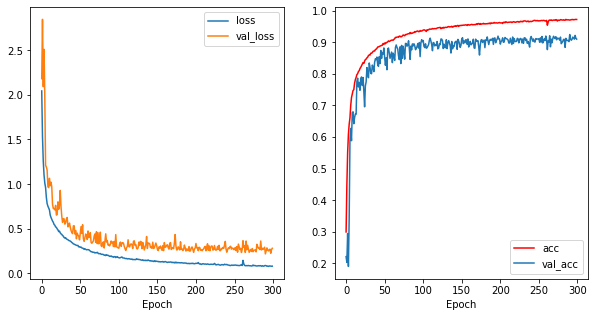

In [17]:
hist = trained_model.history
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.plot(hist['loss'],
       label='loss')
plt.plot( hist['val_loss'],
       label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.plot( hist['acc'],
       label = 'acc',color = 'red')
plt.plot( hist['val_acc'],
       label = 'val_acc')
plt.legend()

In [21]:
def lr_schedule(epoch):
    lr = 0.01
    if epoch > 50:
        lr = 0.001
    print('Learning rate: ', lr)
    return lr


In [22]:
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy(name='acc')
checkpoint=tf.keras.callbacks.ModelCheckpoint('final_model_v4',
                           monitor='val_acc',
                           verbose=1,
                           mode='max',
                           save_weights_only=False,
                           save_best_only=True,
                           period=1)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)


with tf.device("/gpu:0"): 
    inputs=layers.Input(shape=[32,32,3]) 
    outputs=SEResNet50()(inputs)
    model=models.Model(inputs,outputs)
    model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(lr=lr_schedule(0)),
                  metrics=[acc])
    trained_model=model.fit(
        ds_train,
        steps_per_epoch=352,
        shuffle=True,
        epochs=300,
        validation_data=ds_validation,
        validation_steps=40,
        callbacks=[checkpoint, lr_scheduler]
    )

Learning rate:  0.01
Learning rate:  0.01
Epoch 1/300
352/352 [==============================] - ETA: 0s - loss: 1.9494 - acc: 0.3107
Epoch 00001: val_acc improved from -inf to 0.36460, saving model to final_model_v4
INFO:tensorflow:Assets written to: final_model_v4\assets
352/352 [==============================] - 115s 326ms/step - loss: 1.9494 - acc: 0.3107 - val_loss: 1.7116 - val_acc: 0.3646
Learning rate:  0.01
Epoch 2/300
352/352 [==============================] - ETA: 0s - loss: 1.4075 - acc: 0.4926
Epoch 00002: val_acc improved from 0.36460 to 0.42060, saving model to final_model_v4
INFO:tensorflow:Assets written to: final_model_v4\assets
352/352 [==============================] - 113s 320ms/step - loss: 1.4075 - acc: 0.4926 - val_loss: 1.6526 - val_acc: 0.4206
Learning rate:  0.01
Epoch 3/300
352/352 [==============================] - ETA: 0s - loss: 1.1778 - acc: 0.5812
Epoch 00003: val_acc did not improve from 0.42060
352/352 [==============================] - 54s 152ms/step

Learning rate:  0.01
Epoch 26/300
352/352 [==============================] - ETA: 0s - loss: 0.4266 - acc: 0.8526
Epoch 00026: val_acc did not improve from 0.81820
352/352 [==============================] - 53s 150ms/step - loss: 0.4266 - acc: 0.8526 - val_loss: 0.7638 - val_acc: 0.7516
Learning rate:  0.01
Epoch 27/300
352/352 [==============================] - ETA: 0s - loss: 0.4177 - acc: 0.8531
Epoch 00027: val_acc improved from 0.81820 to 0.82520, saving model to final_model_v4
INFO:tensorflow:Assets written to: final_model_v4\assets
352/352 [==============================] - 101s 288ms/step - loss: 0.4177 - acc: 0.8531 - val_loss: 0.5612 - val_acc: 0.8252
Learning rate:  0.01
Epoch 28/300
352/352 [==============================] - ETA: 0s - loss: 0.4061 - acc: 0.8576
Epoch 00028: val_acc did not improve from 0.82520
352/352 [==============================] - 52s 148ms/step - loss: 0.4061 - acc: 0.8576 - val_loss: 0.6113 - val_acc: 0.8152
Learning rate:  0.01
Epoch 29/300
352/352 

352/352 [==============================] - ETA: 0s - loss: 0.2250 - acc: 0.9200
Epoch 00052: val_acc improved from 0.86620 to 0.89800, saving model to final_model_v4
INFO:tensorflow:Assets written to: final_model_v4\assets
352/352 [==============================] - 101s 287ms/step - loss: 0.2250 - acc: 0.9200 - val_loss: 0.2908 - val_acc: 0.8980
Learning rate:  0.001
Epoch 53/300
352/352 [==============================] - ETA: 0s - loss: 0.1966 - acc: 0.9305
Epoch 00053: val_acc improved from 0.89800 to 0.90200, saving model to final_model_v4
INFO:tensorflow:Assets written to: final_model_v4\assets
352/352 [==============================] - 96s 274ms/step - loss: 0.1966 - acc: 0.9305 - val_loss: 0.2757 - val_acc: 0.9020
Learning rate:  0.001
Epoch 54/300
352/352 [==============================] - ETA: 0s - loss: 0.1881 - acc: 0.9339- ETA: 1s - loss: 0.1883 -
Epoch 00054: val_acc improved from 0.90200 to 0.90560, saving model to final_model_v4
INFO:tensorflow:Assets written to: final_mo

Learning rate:  0.001
Epoch 78/300
352/352 [==============================] - ETA: 0s - loss: 0.1354 - acc: 0.9518
Epoch 00078: val_acc did not improve from 0.91760
352/352 [==============================] - 53s 152ms/step - loss: 0.1354 - acc: 0.9518 - val_loss: 0.2404 - val_acc: 0.9158
Learning rate:  0.001
Epoch 79/300
352/352 [==============================] - ETA: 0s - loss: 0.1330 - acc: 0.9525
Epoch 00079: val_acc did not improve from 0.91760
352/352 [==============================] - 53s 149ms/step - loss: 0.1330 - acc: 0.9525 - val_loss: 0.2435 - val_acc: 0.9132
Learning rate:  0.001
Epoch 80/300
352/352 [==============================] - ETA: 0s - loss: 0.1315 - acc: 0.9530
Epoch 00080: val_acc improved from 0.91760 to 0.91780, saving model to final_model_v4
INFO:tensorflow:Assets written to: final_model_v4\assets
352/352 [==============================] - 96s 273ms/step - loss: 0.1315 - acc: 0.9530 - val_loss: 0.2267 - val_acc: 0.9178
Learning rate:  0.001
Epoch 81/300
352/3

Learning rate:  0.001
Epoch 106/300
352/352 [==============================] - ETA: 0s - loss: 0.1099 - acc: 0.9616
Epoch 00106: val_acc did not improve from 0.92240
352/352 [==============================] - 54s 152ms/step - loss: 0.1099 - acc: 0.9616 - val_loss: 0.2332 - val_acc: 0.9202
Learning rate:  0.001
Epoch 107/300
352/352 [==============================] - ETA: 0s - loss: 0.1106 - acc: 0.9610
Epoch 00107: val_acc did not improve from 0.92240
352/352 [==============================] - 52s 149ms/step - loss: 0.1106 - acc: 0.9610 - val_loss: 0.2345 - val_acc: 0.9194
Learning rate:  0.001
Epoch 108/300
352/352 [==============================] - ETA: 0s - loss: 0.1083 - acc: 0.9611
Epoch 00108: val_acc did not improve from 0.92240
352/352 [==============================] - 54s 153ms/step - loss: 0.1083 - acc: 0.9611 - val_loss: 0.2422 - val_acc: 0.9146
Learning rate:  0.001
Epoch 109/300
352/352 [==============================] - ETA: 0s - loss: 0.1096 - acc: 0.9608
Epoch 00109: v

Learning rate:  0.001
Epoch 134/300
352/352 [==============================] - ETA: 0s - loss: 0.0939 - acc: 0.9668
Epoch 00134: val_acc did not improve from 0.92600
352/352 [==============================] - 53s 149ms/step - loss: 0.0939 - acc: 0.9668 - val_loss: 0.2379 - val_acc: 0.9196
Learning rate:  0.001
Epoch 135/300
352/352 [==============================] - ETA: 0s - loss: 0.0945 - acc: 0.9665
Epoch 00135: val_acc did not improve from 0.92600
352/352 [==============================] - 53s 150ms/step - loss: 0.0945 - acc: 0.9665 - val_loss: 0.2308 - val_acc: 0.9210
Learning rate:  0.001
Epoch 136/300
352/352 [==============================] - ETA: 0s - loss: 0.0933 - acc: 0.9672
Epoch 00136: val_acc did not improve from 0.92600
352/352 [==============================] - 52s 149ms/step - loss: 0.0933 - acc: 0.9672 - val_loss: 0.2416 - val_acc: 0.9186
Learning rate:  0.001
Epoch 137/300
352/352 [==============================] - ETA: 0s - loss: 0.0959 - acc: 0.9659
Epoch 00137: v

Learning rate:  0.001
Epoch 162/300
352/352 [==============================] - ETA: 0s - loss: 0.0833 - acc: 0.9705
Epoch 00162: val_acc did not improve from 0.92780
352/352 [==============================] - 54s 152ms/step - loss: 0.0833 - acc: 0.9705 - val_loss: 0.2367 - val_acc: 0.9214
Learning rate:  0.001
Epoch 163/300
352/352 [==============================] - ETA: 0s - loss: 0.0844 - acc: 0.9705
Epoch 00163: val_acc did not improve from 0.92780
352/352 [==============================] - 53s 150ms/step - loss: 0.0844 - acc: 0.9705 - val_loss: 0.2460 - val_acc: 0.9176
Learning rate:  0.001
Epoch 164/300
352/352 [==============================] - ETA: 0s - loss: 0.0821 - acc: 0.9716
Epoch 00164: val_acc did not improve from 0.92780
352/352 [==============================] - 52s 148ms/step - loss: 0.0821 - acc: 0.9716 - val_loss: 0.2505 - val_acc: 0.9204
Learning rate:  0.001
Epoch 165/300
352/352 [==============================] - ETA: 0s - loss: 0.0813 - acc: 0.9711
Epoch 00165: v

Learning rate:  0.001
Epoch 190/300
352/352 [==============================] - ETA: 0s - loss: 0.0766 - acc: 0.9736
Epoch 00190: val_acc did not improve from 0.93020
352/352 [==============================] - 53s 150ms/step - loss: 0.0766 - acc: 0.9736 - val_loss: 0.2323 - val_acc: 0.9200
Learning rate:  0.001
Epoch 191/300
352/352 [==============================] - ETA: 0s - loss: 0.0766 - acc: 0.9733
Epoch 00191: val_acc did not improve from 0.93020
352/352 [==============================] - 54s 153ms/step - loss: 0.0766 - acc: 0.9733 - val_loss: 0.2473 - val_acc: 0.9212
Learning rate:  0.001
Epoch 192/300
352/352 [==============================] - ETA: 0s - loss: 0.0765 - acc: 0.9733
Epoch 00192: val_acc did not improve from 0.93020
352/352 [==============================] - 53s 150ms/step - loss: 0.0765 - acc: 0.9733 - val_loss: 0.2337 - val_acc: 0.9242
Learning rate:  0.001
Epoch 193/300
352/352 [==============================] - ETA: 0s - loss: 0.0745 - acc: 0.9736
Epoch 00193: v

Learning rate:  0.001
Epoch 218/300
352/352 [==============================] - ETA: 0s - loss: 0.0724 - acc: 0.9751
Epoch 00218: val_acc did not improve from 0.93200
352/352 [==============================] - 52s 149ms/step - loss: 0.0724 - acc: 0.9751 - val_loss: 0.2333 - val_acc: 0.9248
Learning rate:  0.001
Epoch 219/300
352/352 [==============================] - ETA: 0s - loss: 0.0658 - acc: 0.9772
Epoch 00219: val_acc did not improve from 0.93200
352/352 [==============================] - 53s 150ms/step - loss: 0.0658 - acc: 0.9772 - val_loss: 0.2363 - val_acc: 0.9244
Learning rate:  0.001
Epoch 220/300
352/352 [==============================] - ETA: 0s - loss: 0.0677 - acc: 0.9766
Epoch 00220: val_acc did not improve from 0.93200
352/352 [==============================] - 53s 151ms/step - loss: 0.0677 - acc: 0.9766 - val_loss: 0.2332 - val_acc: 0.9234
Learning rate:  0.001
Epoch 221/300
352/352 [==============================] - ETA: 0s - loss: 0.0711 - acc: 0.9754
Epoch 00221: v

352/352 [==============================] - ETA: 0s - loss: 0.0647 - acc: 0.9770
Epoch 00246: val_acc did not improve from 0.93200
352/352 [==============================] - 53s 151ms/step - loss: 0.0647 - acc: 0.9770 - val_loss: 0.2531 - val_acc: 0.9184
Learning rate:  0.001
Epoch 247/300
352/352 [==============================] - ETA: 0s - loss: 0.0629 - acc: 0.9782
Epoch 00247: val_acc did not improve from 0.93200
352/352 [==============================] - 53s 149ms/step - loss: 0.0629 - acc: 0.9782 - val_loss: 0.2289 - val_acc: 0.9236
Learning rate:  0.001
Epoch 248/300
352/352 [==============================] - ETA: 0s - loss: 0.0638 - acc: 0.9777
Epoch 00248: val_acc did not improve from 0.93200
352/352 [==============================] - 52s 148ms/step - loss: 0.0638 - acc: 0.9777 - val_loss: 0.2281 - val_acc: 0.9262
Learning rate:  0.001
Epoch 249/300
352/352 [==============================] - ETA: 0s - loss: 0.0647 - acc: 0.9772
Epoch 00249: val_acc did not improve from 0.93200


352/352 [==============================] - ETA: 0s - loss: 0.0590 - acc: 0.9795
Epoch 00274: val_acc did not improve from 0.93200
352/352 [==============================] - 64s 182ms/step - loss: 0.0590 - acc: 0.9795 - val_loss: 0.2470 - val_acc: 0.9228
Learning rate:  0.001
Epoch 275/300
352/352 [==============================] - ETA: 0s - loss: 0.0589 - acc: 0.9799
Epoch 00275: val_acc did not improve from 0.93200
352/352 [==============================] - 67s 189ms/step - loss: 0.0589 - acc: 0.9799 - val_loss: 0.2512 - val_acc: 0.9234
Learning rate:  0.001
Epoch 276/300
352/352 [==============================] - ETA: 0s - loss: 0.0563 - acc: 0.9797
Epoch 00276: val_acc did not improve from 0.93200
352/352 [==============================] - 60s 171ms/step - loss: 0.0563 - acc: 0.9797 - val_loss: 0.2387 - val_acc: 0.9266
Learning rate:  0.001
Epoch 277/300
352/352 [==============================] - ETA: 0s - loss: 0.0596 - acc: 0.9781
Epoch 00277: val_acc did not improve from 0.93200


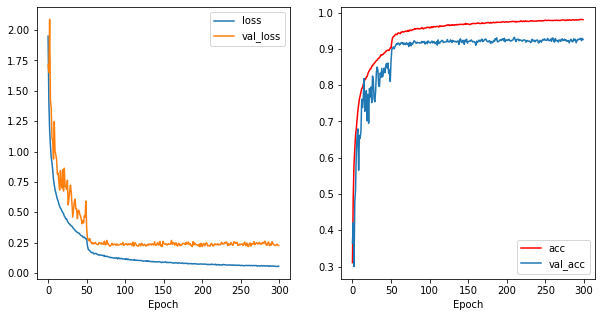

In [23]:
hist = trained_model.history
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.plot(hist['loss'],
       label='loss')
plt.plot( hist['val_loss'],
       label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.plot( hist['acc'],
       label = 'acc',color = 'red')
plt.plot( hist['val_acc'],
       label = 'val_acc')
plt.legend()

In [25]:
def lr_schedule(epoch):
    lr = 0.01
    if epoch > 150:
        lr = 0.0005
    elif epoch >50:
        lr = 0.001
    print('Learning rate: ', lr)
    return lr

In [26]:
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy(name='acc')
checkpoint=tf.keras.callbacks.ModelCheckpoint('final_model_v5',
                           monitor='val_acc',
                           verbose=1,
                           mode='max',
                           save_weights_only=False,
                           save_best_only=True,
                           period=1)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)


with tf.device("/gpu:0"): 
    inputs=layers.Input(shape=[32,32,3]) 
    outputs=SEResNet50()(inputs)
    model=models.Model(inputs,outputs)
    model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(lr=lr_schedule(0)),
                  metrics=[acc])
    trained_model=model.fit(
        ds_train,
        steps_per_epoch=352,
        shuffle=True,
        epochs=500,
        validation_data=ds_validation,
        validation_steps=40,
        callbacks=[checkpoint, lr_scheduler]
    )

Learning rate:  0.01
Learning rate:  0.01
Epoch 1/500
352/352 [==============================] - ETA: 0s - loss: 2.0020 - acc: 0.3078
Epoch 00001: val_acc improved from -inf to 0.15040, saving model to final_model_v5
INFO:tensorflow:Assets written to: final_model_v5\assets
352/352 [==============================] - 103s 294ms/step - loss: 2.0020 - acc: 0.3078 - val_loss: 2.7083 - val_acc: 0.1504
Learning rate:  0.01
Epoch 2/500
352/352 [==============================] - ETA: 0s - loss: 1.4320 - acc: 0.4817
Epoch 00002: val_acc improved from 0.15040 to 0.31780, saving model to final_model_v5
INFO:tensorflow:Assets written to: final_model_v5\assets
352/352 [==============================] - 100s 284ms/step - loss: 1.4320 - acc: 0.4817 - val_loss: 2.0781 - val_acc: 0.3178
Learning rate:  0.01
Epoch 3/500
352/352 [==============================] - ETA: 0s - loss: 1.1702 - acc: 0.5861- ETA: 2s - loss: 1.17
Epoch 00003: val_acc did not improve from 0.31780
352/352 [==========================

Learning rate:  0.01
Epoch 25/500
352/352 [==============================] - ETA: 0s - loss: 0.4203 - acc: 0.8532
Epoch 00025: val_acc did not improve from 0.84260
352/352 [==============================] - 53s 151ms/step - loss: 0.4203 - acc: 0.8532 - val_loss: 0.6383 - val_acc: 0.7886
Learning rate:  0.01
Epoch 26/500
352/352 [==============================] - ETA: 0s - loss: 0.4103 - acc: 0.8561
Epoch 00026: val_acc improved from 0.84260 to 0.85820, saving model to final_model_v5
INFO:tensorflow:Assets written to: final_model_v5\assets
352/352 [==============================] - 107s 303ms/step - loss: 0.4103 - acc: 0.8561 - val_loss: 0.5328 - val_acc: 0.8582
Learning rate:  0.01
Epoch 27/500
352/352 [==============================] - ETA: 0s - loss: 0.4065 - acc: 0.8584
Epoch 00027: val_acc did not improve from 0.85820
352/352 [==============================] - 54s 153ms/step - loss: 0.4065 - acc: 0.8584 - val_loss: 0.6097 - val_acc: 0.7836
Learning rate:  0.01
Epoch 28/500
352/352 

352/352 [==============================] - ETA: 0s - loss: 0.2714 - acc: 0.9051
Epoch 00051: val_acc did not improve from 0.89740
352/352 [==============================] - 58s 164ms/step - loss: 0.2714 - acc: 0.9051 - val_loss: 0.4249 - val_acc: 0.8606
Learning rate:  0.001
Epoch 52/500
352/352 [==============================] - ETA: 0s - loss: 0.2187 - acc: 0.9222
Epoch 00052: val_acc improved from 0.89740 to 0.91200, saving model to final_model_v5
INFO:tensorflow:Assets written to: final_model_v5\assets
352/352 [==============================] - 122s 348ms/step - loss: 0.2187 - acc: 0.9222 - val_loss: 0.2827 - val_acc: 0.9120
Learning rate:  0.001
Epoch 53/500
352/352 [==============================] - ETA: 0s - loss: 0.1956 - acc: 0.9309
Epoch 00053: val_acc improved from 0.91200 to 0.91600, saving model to final_model_v5
INFO:tensorflow:Assets written to: final_model_v5\assets
352/352 [==============================] - 121s 343ms/step - loss: 0.1956 - acc: 0.9309 - val_loss: 0.257

352/352 [==============================] - ETA: 0s - loss: 0.1332 - acc: 0.9527
Epoch 00077: val_acc did not improve from 0.92520
352/352 [==============================] - 58s 164ms/step - loss: 0.1332 - acc: 0.9527 - val_loss: 0.2190 - val_acc: 0.9230
Learning rate:  0.001
Epoch 78/500
352/352 [==============================] - ETA: 0s - loss: 0.1329 - acc: 0.9520
Epoch 00078: val_acc did not improve from 0.92520
352/352 [==============================] - 58s 165ms/step - loss: 0.1329 - acc: 0.9520 - val_loss: 0.2301 - val_acc: 0.9192
Learning rate:  0.001
Epoch 79/500
352/352 [==============================] - ETA: 0s - loss: 0.1301 - acc: 0.9544
Epoch 00079: val_acc improved from 0.92520 to 0.92920, saving model to final_model_v5
INFO:tensorflow:Assets written to: final_model_v5\assets
352/352 [==============================] - 120s 340ms/step - loss: 0.1301 - acc: 0.9544 - val_loss: 0.2168 - val_acc: 0.9292
Learning rate:  0.001
Epoch 80/500
352/352 [==============================

Learning rate:  0.001
Epoch 105/500
352/352 [==============================] - ETA: 0s - loss: 0.1083 - acc: 0.9619
Epoch 00105: val_acc did not improve from 0.92920
352/352 [==============================] - 58s 164ms/step - loss: 0.1083 - acc: 0.9619 - val_loss: 0.2127 - val_acc: 0.9266
Learning rate:  0.001
Epoch 106/500
352/352 [==============================] - ETA: 0s - loss: 0.1093 - acc: 0.9611
Epoch 00106: val_acc did not improve from 0.92920
352/352 [==============================] - 57s 163ms/step - loss: 0.1093 - acc: 0.9611 - val_loss: 0.2211 - val_acc: 0.9224
Learning rate:  0.001
Epoch 107/500
352/352 [==============================] - ETA: 0s - loss: 0.1064 - acc: 0.9627
Epoch 00107: val_acc did not improve from 0.92920
352/352 [==============================] - 58s 164ms/step - loss: 0.1064 - acc: 0.9627 - val_loss: 0.2158 - val_acc: 0.9262
Learning rate:  0.001
Epoch 108/500
352/352 [==============================] - ETA: 0s - loss: 0.1061 - acc: 0.9629
Epoch 00108: v

Learning rate:  0.001
Epoch 132/500
352/352 [==============================] - ETA: 0s - loss: 0.0948 - acc: 0.9664
Epoch 00132: val_acc did not improve from 0.93420
352/352 [==============================] - 54s 153ms/step - loss: 0.0948 - acc: 0.9664 - val_loss: 0.2087 - val_acc: 0.9280
Learning rate:  0.001
Epoch 133/500
352/352 [==============================] - ETA: 0s - loss: 0.0913 - acc: 0.9678
Epoch 00133: val_acc did not improve from 0.93420
352/352 [==============================] - 55s 156ms/step - loss: 0.0913 - acc: 0.9678 - val_loss: 0.2010 - val_acc: 0.9300
Learning rate:  0.001
Epoch 134/500
352/352 [==============================] - ETA: 0s - loss: 0.0928 - acc: 0.9669
Epoch 00134: val_acc did not improve from 0.93420
352/352 [==============================] - 54s 153ms/step - loss: 0.0928 - acc: 0.9669 - val_loss: 0.1934 - val_acc: 0.9316
Learning rate:  0.001
Epoch 135/500
352/352 [==============================] - ETA: 0s - loss: 0.0932 - acc: 0.9670
Epoch 00135: v

Learning rate:  0.0005
Epoch 160/500
352/352 [==============================] - ETA: 0s - loss: 0.0793 - acc: 0.9713
Epoch 00160: val_acc did not improve from 0.93580
352/352 [==============================] - 54s 153ms/step - loss: 0.0793 - acc: 0.9713 - val_loss: 0.1938 - val_acc: 0.9326
Learning rate:  0.0005
Epoch 161/500
352/352 [==============================] - ETA: 0s - loss: 0.0776 - acc: 0.9719
Epoch 00161: val_acc did not improve from 0.93580
352/352 [==============================] - 54s 155ms/step - loss: 0.0776 - acc: 0.9719 - val_loss: 0.1893 - val_acc: 0.9328
Learning rate:  0.0005
Epoch 162/500
352/352 [==============================] - ETA: 0s - loss: 0.0796 - acc: 0.9720
Epoch 00162: val_acc did not improve from 0.93580
352/352 [==============================] - 53s 151ms/step - loss: 0.0796 - acc: 0.9720 - val_loss: 0.1890 - val_acc: 0.9348
Learning rate:  0.0005
Epoch 163/500
352/352 [==============================] - ETA: 0s - loss: 0.0801 - acc: 0.9726
Epoch 0016

Learning rate:  0.0005
Epoch 188/500
352/352 [==============================] - ETA: 0s - loss: 0.0719 - acc: 0.9743
Epoch 00188: val_acc did not improve from 0.93580
352/352 [==============================] - 54s 153ms/step - loss: 0.0719 - acc: 0.9743 - val_loss: 0.1956 - val_acc: 0.9322
Learning rate:  0.0005
Epoch 189/500
352/352 [==============================] - ETA: 0s - loss: 0.0717 - acc: 0.9741
Epoch 00189: val_acc did not improve from 0.93580
352/352 [==============================] - 54s 154ms/step - loss: 0.0717 - acc: 0.9741 - val_loss: 0.1945 - val_acc: 0.9320
Learning rate:  0.0005
Epoch 190/500
352/352 [==============================] - ETA: 0s - loss: 0.0730 - acc: 0.9747
Epoch 00190: val_acc did not improve from 0.93580
352/352 [==============================] - 54s 153ms/step - loss: 0.0730 - acc: 0.9747 - val_loss: 0.1927 - val_acc: 0.9324
Learning rate:  0.0005
Epoch 191/500
352/352 [==============================] - ETA: 0s - loss: 0.0721 - acc: 0.9739
Epoch 0019

352/352 [==============================] - ETA: 0s - loss: 0.0670 - acc: 0.9766
Epoch 00216: val_acc did not improve from 0.93580
352/352 [==============================] - 58s 165ms/step - loss: 0.0670 - acc: 0.9766 - val_loss: 0.1928 - val_acc: 0.9338
Learning rate:  0.0005
Epoch 217/500
352/352 [==============================] - ETA: 0s - loss: 0.0684 - acc: 0.9765- ETA: 1s - loss: 0.0679 - acc:  - ETA: 0s - loss: 0.0682 - acc: 0
Epoch 00217: val_acc did not improve from 0.93580
352/352 [==============================] - 61s 173ms/step - loss: 0.0684 - acc: 0.9765 - val_loss: 0.1950 - val_acc: 0.9346
Learning rate:  0.0005
Epoch 218/500
352/352 [==============================] - ETA: 0s - loss: 0.0658 - acc: 0.9765- ETA: 7s - loss: 0.0674 - ETA: 5s 
Epoch 00218: val_acc did not improve from 0.93580
352/352 [==============================] - 69s 195ms/step - loss: 0.0658 - acc: 0.9765 - val_loss: 0.2001 - val_acc: 0.9320
Learning rate:  0.0005
Epoch 219/500
352/352 [=================

Learning rate:  0.0005
Epoch 244/500
352/352 [==============================] - ETA: 0s - loss: 0.0663 - acc: 0.9770
Epoch 00244: val_acc did not improve from 0.93580
352/352 [==============================] - 54s 154ms/step - loss: 0.0663 - acc: 0.9770 - val_loss: 0.2046 - val_acc: 0.9304
Learning rate:  0.0005
Epoch 245/500
352/352 [==============================] - ETA: 0s - loss: 0.0647 - acc: 0.9771
Epoch 00245: val_acc did not improve from 0.93580
352/352 [==============================] - 54s 153ms/step - loss: 0.0647 - acc: 0.9771 - val_loss: 0.2074 - val_acc: 0.9302
Learning rate:  0.0005
Epoch 246/500
352/352 [==============================] - ETA: 0s - loss: 0.0637 - acc: 0.9770
Epoch 00246: val_acc did not improve from 0.93580
352/352 [==============================] - 55s 156ms/step - loss: 0.0637 - acc: 0.9770 - val_loss: 0.1958 - val_acc: 0.9324
Learning rate:  0.0005
Epoch 247/500
352/352 [==============================] - ETA: 0s - loss: 0.0648 - acc: 0.9775
Epoch 0024

352/352 [==============================] - ETA: 0s - loss: 0.0608 - acc: 0.9785
Epoch 00272: val_acc did not improve from 0.93580
352/352 [==============================] - 57s 163ms/step - loss: 0.0608 - acc: 0.9785 - val_loss: 0.1953 - val_acc: 0.9352
Learning rate:  0.0005
Epoch 273/500
352/352 [==============================] - ETA: 0s - loss: 0.0617 - acc: 0.9783
Epoch 00273: val_acc did not improve from 0.93580
352/352 [==============================] - 58s 165ms/step - loss: 0.0617 - acc: 0.9783 - val_loss: 0.2045 - val_acc: 0.9324
Learning rate:  0.0005
Epoch 274/500
352/352 [==============================] - ETA: 0s - loss: 0.0608 - acc: 0.9794
Epoch 00274: val_acc did not improve from 0.93580
352/352 [==============================] - 55s 156ms/step - loss: 0.0608 - acc: 0.9794 - val_loss: 0.1953 - val_acc: 0.9328
Learning rate:  0.0005
Epoch 275/500
352/352 [==============================] - ETA: 0s - loss: 0.0613 - acc: 0.9790
Epoch 00275: val_acc did not improve from 0.935

Learning rate:  0.0005
Epoch 300/500
352/352 [==============================] - ETA: 0s - loss: 0.0583 - acc: 0.9794
Epoch 00300: val_acc did not improve from 0.93700
352/352 [==============================] - 54s 155ms/step - loss: 0.0583 - acc: 0.9794 - val_loss: 0.1955 - val_acc: 0.9342
Learning rate:  0.0005
Epoch 301/500
352/352 [==============================] - ETA: 0s - loss: 0.0563 - acc: 0.9799
Epoch 00301: val_acc did not improve from 0.93700
352/352 [==============================] - 54s 152ms/step - loss: 0.0563 - acc: 0.9799 - val_loss: 0.1941 - val_acc: 0.9338
Learning rate:  0.0005
Epoch 302/500
352/352 [==============================] - ETA: 0s - loss: 0.0593 - acc: 0.9789
Epoch 00302: val_acc did not improve from 0.93700
352/352 [==============================] - 55s 157ms/step - loss: 0.0593 - acc: 0.9789 - val_loss: 0.2037 - val_acc: 0.9312
Learning rate:  0.0005
Epoch 303/500
352/352 [==============================] - ETA: 0s - loss: 0.0600 - acc: 0.9794
Epoch 0030

352/352 [==============================] - ETA: 0s - loss: 0.0550 - acc: 0.9805
Epoch 00327: val_acc did not improve from 0.93700
352/352 [==============================] - 61s 173ms/step - loss: 0.0550 - acc: 0.9805 - val_loss: 0.2120 - val_acc: 0.9314
Learning rate:  0.0005
Epoch 328/500
352/352 [==============================] - ETA: 0s - loss: 0.0553 - acc: 0.9805
Epoch 00328: val_acc did not improve from 0.93700
352/352 [==============================] - 60s 170ms/step - loss: 0.0553 - acc: 0.9805 - val_loss: 0.2060 - val_acc: 0.9318
Learning rate:  0.0005
Epoch 329/500
352/352 [==============================] - ETA: 0s - loss: 0.0554 - acc: 0.9803
Epoch 00329: val_acc did not improve from 0.93700
352/352 [==============================] - 58s 165ms/step - loss: 0.0554 - acc: 0.9803 - val_loss: 0.2116 - val_acc: 0.9298
Learning rate:  0.0005
Epoch 330/500
352/352 [==============================] - ETA: 0s - loss: 0.0530 - acc: 0.9818
Epoch 00330: val_acc did not improve from 0.937

352/352 [==============================] - ETA: 0s - loss: 0.0518 - acc: 0.9830
Epoch 00355: val_acc did not improve from 0.93700
352/352 [==============================] - 62s 176ms/step - loss: 0.0518 - acc: 0.9830 - val_loss: 0.2185 - val_acc: 0.9290
Learning rate:  0.0005
Epoch 356/500
352/352 [==============================] - ETA: 0s - loss: 0.0517 - acc: 0.9824
Epoch 00356: val_acc did not improve from 0.93700
352/352 [==============================] - 59s 167ms/step - loss: 0.0517 - acc: 0.9824 - val_loss: 0.2076 - val_acc: 0.9332
Learning rate:  0.0005
Epoch 357/500
352/352 [==============================] - ETA: 0s - loss: 0.0527 - acc: 0.9818
Epoch 00357: val_acc did not improve from 0.93700
352/352 [==============================] - 57s 163ms/step - loss: 0.0527 - acc: 0.9818 - val_loss: 0.2112 - val_acc: 0.9306
Learning rate:  0.0005
Epoch 358/500
352/352 [==============================] - ETA: 0s - loss: 0.0514 - acc: 0.9824
Epoch 00358: val_acc did not improve from 0.937

352/352 [==============================] - ETA: 0s - loss: 0.0483 - acc: 0.9834
Epoch 00383: val_acc did not improve from 0.93700
352/352 [==============================] - 54s 153ms/step - loss: 0.0483 - acc: 0.9834 - val_loss: 0.2079 - val_acc: 0.9326
Learning rate:  0.0005
Epoch 384/500
352/352 [==============================] - ETA: 0s - loss: 0.0513 - acc: 0.9826
Epoch 00384: val_acc did not improve from 0.93700
352/352 [==============================] - 53s 151ms/step - loss: 0.0513 - acc: 0.9826 - val_loss: 0.2130 - val_acc: 0.9338
Learning rate:  0.0005
Epoch 385/500
352/352 [==============================] - ETA: 0s - loss: 0.0502 - acc: 0.9828
Epoch 00385: val_acc did not improve from 0.93700
352/352 [==============================] - 54s 154ms/step - loss: 0.0502 - acc: 0.9828 - val_loss: 0.2148 - val_acc: 0.9324
Learning rate:  0.0005
Epoch 386/500
352/352 [==============================] - ETA: 0s - loss: 0.0477 - acc: 0.9831
Epoch 00386: val_acc did not improve from 0.937

Learning rate:  0.0005
Epoch 411/500
352/352 [==============================] - ETA: 0s - loss: 0.0472 - acc: 0.9834
Epoch 00411: val_acc did not improve from 0.93880
352/352 [==============================] - 53s 151ms/step - loss: 0.0472 - acc: 0.9834 - val_loss: 0.2235 - val_acc: 0.9300
Learning rate:  0.0005
Epoch 412/500
352/352 [==============================] - ETA: 0s - loss: 0.0483 - acc: 0.9835
Epoch 00412: val_acc did not improve from 0.93880
352/352 [==============================] - 54s 153ms/step - loss: 0.0483 - acc: 0.9835 - val_loss: 0.2143 - val_acc: 0.9300
Learning rate:  0.0005
Epoch 413/500
352/352 [==============================] - ETA: 0s - loss: 0.0488 - acc: 0.9830
Epoch 00413: val_acc did not improve from 0.93880
352/352 [==============================] - 53s 150ms/step - loss: 0.0488 - acc: 0.9830 - val_loss: 0.2029 - val_acc: 0.9334
Learning rate:  0.0005
Epoch 414/500
352/352 [==============================] - ETA: 0s - loss: 0.0474 - acc: 0.9831
Epoch 0041

352/352 [==============================] - ETA: 0s - loss: 0.0462 - acc: 0.9843
Epoch 00439: val_acc did not improve from 0.93880
352/352 [==============================] - 54s 152ms/step - loss: 0.0462 - acc: 0.9843 - val_loss: 0.2001 - val_acc: 0.9356
Learning rate:  0.0005
Epoch 440/500
352/352 [==============================] - ETA: 0s - loss: 0.0479 - acc: 0.9836
Epoch 00440: val_acc did not improve from 0.93880
352/352 [==============================] - 53s 150ms/step - loss: 0.0479 - acc: 0.9836 - val_loss: 0.2101 - val_acc: 0.9338
Learning rate:  0.0005
Epoch 441/500
352/352 [==============================] - ETA: 0s - loss: 0.0465 - acc: 0.9838
Epoch 00441: val_acc did not improve from 0.93880
352/352 [==============================] - 53s 151ms/step - loss: 0.0465 - acc: 0.9838 - val_loss: 0.2071 - val_acc: 0.9338
Learning rate:  0.0005
Epoch 442/500
352/352 [==============================] - ETA: 0s - loss: 0.0455 - acc: 0.9844
Epoch 00442: val_acc did not improve from 0.938

352/352 [==============================] - ETA: 0s - loss: 0.0437 - acc: 0.9848
Epoch 00467: val_acc did not improve from 0.93880
352/352 [==============================] - 53s 150ms/step - loss: 0.0437 - acc: 0.9848 - val_loss: 0.2069 - val_acc: 0.9348
Learning rate:  0.0005
Epoch 468/500
352/352 [==============================] - ETA: 0s - loss: 0.0454 - acc: 0.9844
Epoch 00468: val_acc did not improve from 0.93880
352/352 [==============================] - 55s 156ms/step - loss: 0.0454 - acc: 0.9844 - val_loss: 0.2046 - val_acc: 0.9350
Learning rate:  0.0005
Epoch 469/500
352/352 [==============================] - ETA: 0s - loss: 0.0416 - acc: 0.9860
Epoch 00469: val_acc did not improve from 0.93880
352/352 [==============================] - 54s 154ms/step - loss: 0.0416 - acc: 0.9860 - val_loss: 0.2152 - val_acc: 0.9330
Learning rate:  0.0005
Epoch 470/500
352/352 [==============================] - ETA: 0s - loss: 0.0448 - acc: 0.9839
Epoch 00470: val_acc did not improve from 0.938

352/352 [==============================] - ETA: 0s - loss: 0.0427 - acc: 0.9846
Epoch 00495: val_acc did not improve from 0.93880
352/352 [==============================] - 53s 151ms/step - loss: 0.0427 - acc: 0.9846 - val_loss: 0.2204 - val_acc: 0.9306
Learning rate:  0.0005
Epoch 496/500
352/352 [==============================] - ETA: 0s - loss: 0.0400 - acc: 0.9857
Epoch 00496: val_acc did not improve from 0.93880
352/352 [==============================] - 53s 151ms/step - loss: 0.0400 - acc: 0.9857 - val_loss: 0.2090 - val_acc: 0.9320
Learning rate:  0.0005
Epoch 497/500
352/352 [==============================] - ETA: 0s - loss: 0.0416 - acc: 0.9859
Epoch 00497: val_acc did not improve from 0.93880
352/352 [==============================] - 53s 152ms/step - loss: 0.0416 - acc: 0.9859 - val_loss: 0.2065 - val_acc: 0.9336
Learning rate:  0.0005
Epoch 498/500
352/352 [==============================] - ETA: 0s - loss: 0.0404 - acc: 0.9857
Epoch 00498: val_acc did not improve from 0.938